# Stock Price Predictor: SPY Index

Zachary Miller | zjm1547 | CS349 Machine Learning

Adapted from https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136

Adapted from https://www.kaggle.com/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

## 1. Importing Modules

In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
import requests
from numpy import newaxis
import os

<ipython-input-1-b08e7b4979c1>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 2. Download Data from TwelveData

In [2]:
def get_stock_price(symbol, interval, days, end_date=None):
    api_key = 'da3f527a23d8426893db7aeeee3d9813'
    if end_date:
        api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval={interval}&outputsize={days}&apikey={api_key}&end_date={end_date}'
    else:
        api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval={interval}&outputsize={days}&apikey={api_key}'
    raw = requests.get(api_url).json()
    df = pd.DataFrame(raw['values']).set_index('datetime')
    df = df.iloc[::-1]
    return df

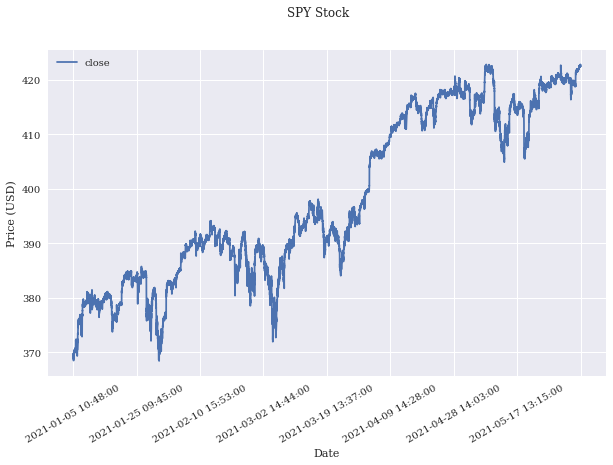

In [3]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbol = 'SPY'
df = get_stock_price(symbol, "1min", 5000)

for x in range(7):
    btc = get_stock_price(symbol, "1min", 5000, df.index[0])
    df = pd.concat([btc, df])

df = df[['close']]
df['close'] = df['close'].astype('float')
df.plot(figsize=(10, 6), subplots=True, title=symbol+" Stock", xlabel="Date", ylabel="Price (USD)", rot=30);

In [4]:
df=df[['close']]

df=df.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df['close'] = scaler.fit_transform(df['close'].values.reshape(-1,1))


## 3. Build Testing & Training Sets

In [5]:
def load_data(stock, look_back):
    data_raw = df.close
    data = []
    
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1]
    x_train = x_train[..., newaxis]
    y_train = data[:train_set_size,-1]
    y_train = y_train[..., newaxis]
    
    x_test = data[train_set_size:,:-1]
    x_test = x_test[..., newaxis]
    y_test = data[train_set_size:,-1]
    y_test = y_test[..., newaxis]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (31952, 59, 1)
y_train.shape =  (31952, 1)
x_test.shape =  (7988, 59, 1)
y_test.shape =  (7988, 1)


In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## 4. Define the Model Class

In [7]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

## 5. Train Model

In [8]:
num_epochs = 100
hist = np.zeros(num_epochs)

seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

Epoch  10 MSE:  0.016897985711693764
Epoch  20 MSE:  0.008107665926218033
Epoch  30 MSE:  0.005363314412534237
Epoch  40 MSE:  0.0012865065364167094
Epoch  50 MSE:  0.0005095673259347677
Epoch  60 MSE:  0.0002475718501955271
Epoch  70 MSE:  0.00014142321015242487
Epoch  80 MSE:  0.00011834791075671092
Epoch  90 MSE:  0.00011586223263293505


## 6. Visualizing Loss, Model Performance

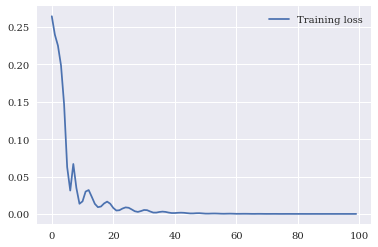

In [9]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [10]:
y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

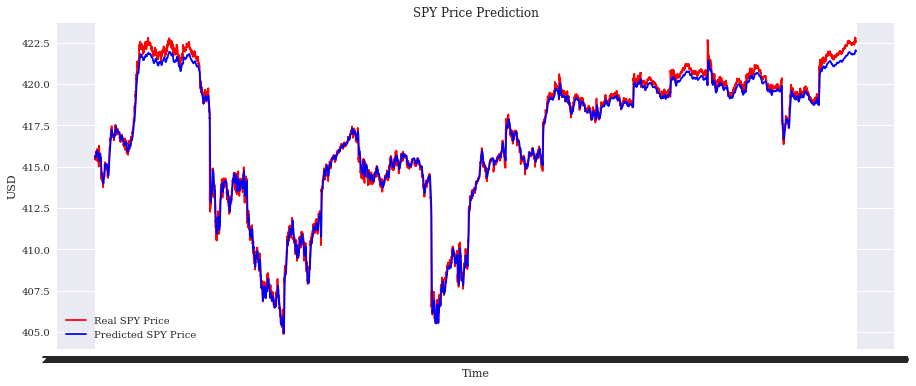

In [11]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real ' + symbol + ' Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted ' + symbol +' Price')
plt.title(symbol + ' Price Prediction')
plt.xlabel('Time')
plt.ylabel('USD')
plt.legend()
plt.show()

## 7. Directionality Test

What percent of the time does the model correctly predict bullish and bearish movements?

In [12]:
test_change = []
prediction_change = []

for x in range(1,len(y_test)):
    test_change.append(y_test[x]-y_test[x-1])
    prediction_change.append(y_test_pred[x]-y_test[x-1])

test_change = np.array(test_change)
prediction_change = np.array(prediction_change)

#If y(i) and pred(i) are both positive or both negative, product(i) will be positive. Negative otherwise.
product = np.multiply(test_change, prediction_change)

res = (len([ele for ele in product if ele > 0]) / len(product)) * 100

print("Correct direction predicted in " + str(res) + "% of cases.")

Correct direction predicted in 48.35357455865782% of cases.
